### Evaluate Models

- Joel Stremmel
- 04-21-23

##### About

Loads the true labels and predicted probabilities of each label for each fold for each model and computes performance metrics.

##### Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

##### Evaluation Parameters

In [2]:
threshold = 0.5
num_std = 1.96
line_width = 2
alpha = 0.2
font_size = 16
legend_size = 10
x_size = 10
y_size = 10

##### Load Labels and Predictions for each Model

In [3]:
all_y_trues, all_y_probs = [], []
all_model_names = {
    "lr": "L2 Reg Logistic Regression",
    "nb": "Naive Bayes Classifier",
    "knn": "K-Nearest Neighbors Classifier",
    "gd_svm": "Support Vector Machine",
    "roberta_large": "RoBERTa Large",
    "bb_large": "Big Bird Large"
}
#     'lfb': 'Longformer Base',
#     'bbl': 'Big Bird Large',
#     'gpt_neo_1_3b': 'GPT-Neo 1.3B',
# }

# https://gist.github.com/thriveth/8560036
color_map = {
    "blue": "#377eb8",
    "red": "#e41a1c",
    "brown": "#a65628",
    "orange": "#ff7f00",
    'green':   '#4daf4a',
    'purple':  '#984ea3'
}
#     'yellow':  '#FFFF00'
# }
colors = list(color_map.values())

with open(f"results/sklearn_y_trues.pkl", "rb") as f:
    sklearn_y_trues = pickle.load(f)

with open(f"results/sklearn_y_probs.pkl", "rb") as f:
    sklearn_y_probs = pickle.load(f)

with open(f"results/lm_y_trues.pkl", "rb") as f:
    lm_y_trues = pickle.load(f)

with open(f"results/lm_y_probs.pkl", "rb") as f:
    lm_y_probs = pickle.load(f)

y_trues = {**sklearn_y_trues, **lm_y_trues}
y_probs = {**sklearn_y_probs, **lm_y_probs}

for key in all_model_names.keys():
    all_y_trues.append(y_trues[key])
    all_y_probs.append(y_probs[key])

##### Define a Function to Print the Mean and Confidence Interval for a Given Metric

In [6]:
def print_mean_ci_of_metric_list(metric_list, metric_name, num_std):
    mean_metric = np.mean(metric_list)
    std_metric = np.std(metric_list)
    metric_low = np.maximum(mean_metric - std_metric * num_std, 0)
    metric_high = np.minimum(mean_metric + std_metric * num_std, 1)

    print(
        f"{metric_name}: {round(mean_metric, 3)} [{round(metric_low, 3)} - {round(metric_high, 3)}]"
    )

##### Print Performance for all Metrics for all Models

In [7]:
for y_trues, y_probs, name, color in zip(
    all_y_trues, all_y_probs, all_model_names.values(), colors
):
    accuracies, aps, precisions, recalls = [], [], [], []
    for y_true, y_prob in zip(y_trues, y_probs):
        y_pred = [1 if x >= threshold else 0 for x in y_prob]

        accuracy = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
        accuracies.append(accuracy)

        ap = metrics.average_precision_score(y_true=y_true, y_score=y_prob)
        aps.append(ap)

        precision = metrics.precision_score(y_true=y_true, y_pred=y_pred)
        precisions.append(precision)

        recall = metrics.recall_score(y_true=y_true, y_pred=y_pred)
        recalls.append(recall)

    print(f"\nResults for model: {name}\n")
    print_mean_ci_of_metric_list(accuracies, metric_name="Accuracy", num_std=num_std)
    print_mean_ci_of_metric_list(aps, metric_name="Average Precision", num_std=num_std)
    print_mean_ci_of_metric_list(precision, metric_name="Precision", num_std=num_std)
    print_mean_ci_of_metric_list(recall, metric_name="Recall", num_std=num_std)


Results for model: L2 Reg Logistic Regression

Accuracy: 0.407 [0.177 - 0.638]
Average Precision: 0.892 [0.76 - 1.0]
Precision: 0.5 [0.5 - 0.5]
Recall: 0.571 [0.571 - 0.571]

Results for model: Naive Bayes Classifier

Accuracy: 0.697 [0.544 - 0.851]
Average Precision: 0.824 [0.575 - 1.0]
Precision: 0.6 [0.6 - 0.6]
Recall: 0.857 [0.857 - 0.857]

Results for model: K-Nearest Neighbors Classifier

Accuracy: 0.527 [0.382 - 0.673]
Average Precision: 0.659 [0.514 - 0.805]
Precision: 0.5 [0.5 - 0.5]
Recall: 0.286 [0.286 - 0.286]

Results for model: Support Vector Machine

Accuracy: 0.723 [0.471 - 0.974]
Average Precision: 0.741 [0.533 - 0.949]
Precision: 0.667 [0.667 - 0.667]
Recall: 0.571 [0.571 - 0.571]


/home/joel_stremmel/anaconda3/envs/transcripts/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Plot Model ROC AUCs on the Same Graph with Confidence Intervals

<Figure size 640x480 with 0 Axes>

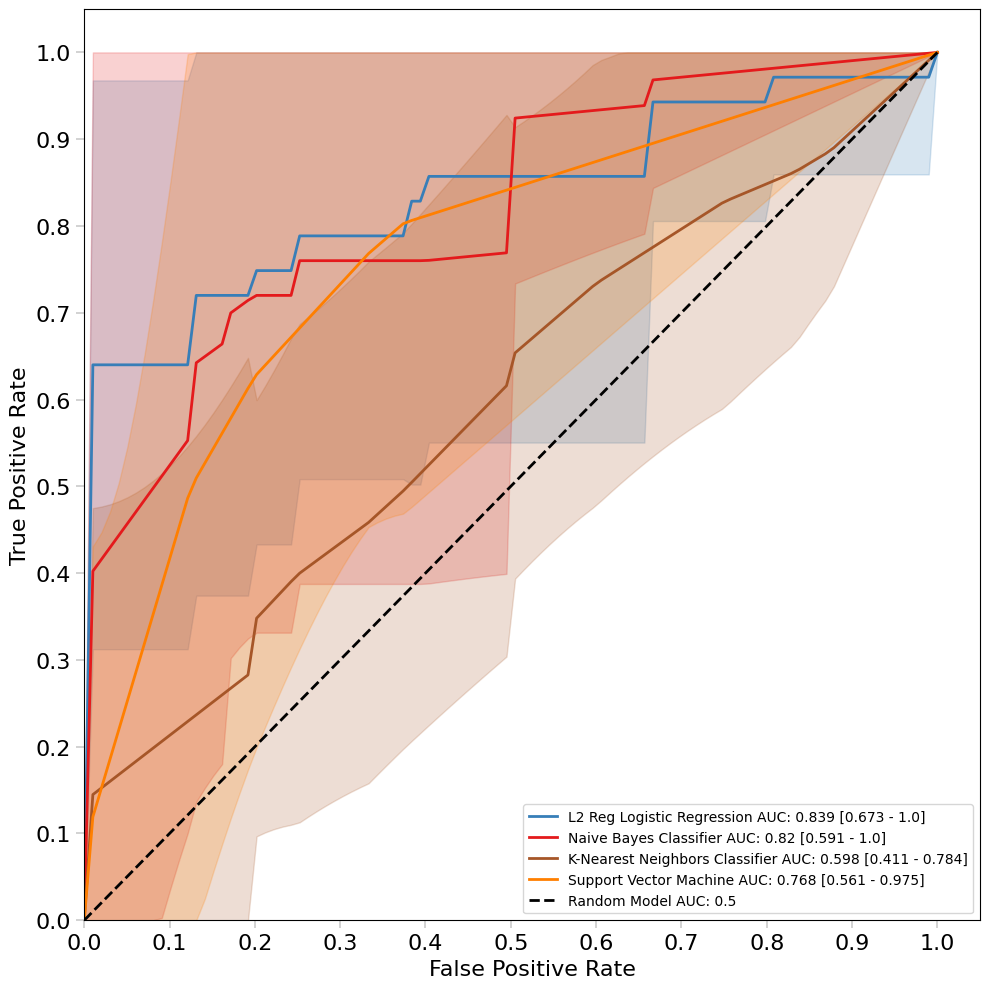

In [8]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(x_size, y_size))

for y_trues, y_probs, name, color in zip(
    all_y_trues, all_y_probs, all_model_names.values(), colors
):
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)

    for y_true, y_prob in zip(y_trues, y_probs):
        fpr, tpr, _ = metrics.roc_curve(y_true, y_prob)

        auc = metrics.roc_auc_score(y_true, y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    tprs_high = np.minimum(mean_tpr + num_std * std_tpr, 1)
    tprs_low = np.maximum(mean_tpr - num_std * std_tpr, 0)

    mean_auc = np.mean(aucs, axis=0)
    std_auc = np.std(aucs, axis=0)
    auc_high = np.minimum(mean_auc + num_std * std_auc, 1)
    auc_low = np.maximum(mean_auc - num_std * std_auc, 0)

    ax.plot(
        mean_fpr,
        mean_tpr,
        color=color,
        lw=line_width,
        label=f"{name} AUC: {round(mean_auc, 3)} [{round(auc_low, 3)} - {round(auc_high, 3)}]",
    )

    ax.fill_between(mean_fpr, tprs_low, tprs_high, color=color, alpha=alpha)

plt.plot(
    [0, 1],
    [0, 1],
    color="black",
    lw=line_width,
    linestyle="--",
    label="Random Model AUC: 0.5",
)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_xticks(np.arange(0, 1.1, 0.1), minor=True)
ax.tick_params(
    direction="out", length=6, width=0.25, colors="black", labelsize=font_size
)
ax.tick_params(axis="both", which="minor", width=0.25)
plt.xlabel("False Positive Rate", fontsize=font_size)
plt.ylabel("True Positive Rate", fontsize=font_size)
plt.legend(loc="lower right", fontsize=legend_size)
plt.tight_layout()
plt.savefig("results/roc.png")
plt.show()
plt.close()